In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
import math
from sklearn.model_selection import train_test_split

## Load the Dataset

In [17]:
data = load_iris()

X, y = data['data'],data['target']

## Visualize the data

Lets visualize what type of distribution does sepal length has. 

(array([ 0.,  0.,  4., 12., 29., 20., 24., 26., 18.,  9.,  3.,  5.,  0.]),
 array([3.3, 3.7, 4.1, 4.5, 4.9, 5.3, 5.7, 6.1, 6.5, 6.9, 7.3, 7.7, 8.1,
        8.5]),
 <BarContainer object of 13 artists>)

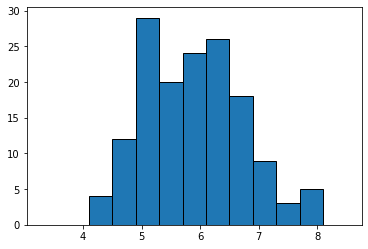

In [18]:
bins = np.arange(min(X[:,0]) -1,max(X[:,0])+1,0.4)

plt.hist(X[:,0],bins,histtype='bar',ec='black')

The distribution is kind of like Normal/ Gaussian Distribution

## Convert to Dataframe with column names

In [19]:
dataset = np.append(X,y.reshape(y.shape[0],1),axis=1)

dataset = pd.DataFrame(dataset)

dataset = dataset.rename(columns={0:'sepal length',1:'sepal width',2:'petal length',3:'petal width',4:'class'})

## Shuffle

In [20]:
def Random_shuffle(dataset):
    for i in range(100):
        dataset = dataset.sample(frac=1).reset_index(drop=True)
    return dataset

dataset = Random_shuffle(dataset)

## Preprocessing

In [21]:
def PreProcessing(dataset):
    X = dataset.drop([dataset.columns[-1]],axis=1)
    y = dataset[dataset.columns[-1]]
    
    return X,y

X, y = PreProcessing(dataset)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## Helper Methods

In [23]:
def Convert_to_numpy_array(array):
    arr = np.fromiter(array.values(),dtype=float)
    return arr

# Naive Bayes Implementation

### Prior Probability

In [24]:
##Calculate the Prior Probabilites
def Prior_Probability(y):
    
    total_samples = y.shape[0]
    setosa = len(y[y==0])/total_samples
    versicolor = len(y[y==1])/total_samples
    virginica = len(y[y==2])/total_samples
    
    Prior_Prob = {
        0 : format(setosa,".3f"),
        1: format(versicolor,".3f"),
        2: format(virginica,".3f")
    }
    map_class_to_label = {
        0: "setosa",
        1: "versicolor",
        2: "virginica"
    }
    return Prior_Prob,map_class_to_label


Prior_Prob,class_to_label_map = Prior_Probability(y)

print("Prior Probability for setosa:",Prior_Prob[0])
print("Prior Probability for versicolor:",Prior_Prob[1])
print("Prior Probability for virginica:",Prior_Prob[2])

Prior Probability for setosa: 0.333
Prior Probability for versicolor: 0.333
Prior Probability for virginica: 0.333


### Mean & Variance for Each Features

In [25]:
def Calc_mean_variance(x):
    features_mean = np.mean(x,axis=0)
    
    mean_of_features = {
        0: format(features_mean['sepal length'],".3f"),
        1: format(features_mean['sepal width'],".3f"),
        2: format(features_mean['petal length'],".3f"),
        3: format(features_mean['petal width'],".3f")
    }
    
    features_variance = np.var(x,axis=0)
    
    var_of_features = {
        0: format(features_variance['sepal length'],".3f"),
        1: format(features_variance['sepal width'],".3f"),
        2: format(features_variance['petal length'],".3f"),
        3: format(features_variance['petal width'],".3f")
    }
    
    return mean_of_features,var_of_features

mean, variance  = Calc_mean_variance(X)

print("\t\tSepal Length\tSepal Width\tPetal Length\tPetal Width")
print("Mean\t\t",mean[0],'\t\t',mean[1],'\t\t',mean[2],'\t\t',mean[3])
print("\nVariance\t",variance[0],'\t\t',variance[1],'\t\t',\
      variance[2],'\t\t',variance[3])

mean = Convert_to_numpy_array(mean)
variance = Convert_to_numpy_array(variance)

		Sepal Length	Sepal Width	Petal Length	Petal Width
Mean		 5.843 		 3.057 		 3.758 		 1.199

Variance	 0.681 		 0.189 		 3.096 		 0.577


### Mean and Variance per Class

In [26]:
def Calc_mean_var_per_class(dataset):
    mean = []
    variance = []
    for i in np.unique(dataset['class']):
        df = dataset[dataset['class'] == i]
        mu,var = Calc_mean_variance(df.loc[:,df.columns!='class'])
        mean_arr = Convert_to_numpy_array(mu)
        variance_arr = Convert_to_numpy_array(var)
        mean.append(mean_arr)
        variance.append(variance_arr)
    
    return (np.array(mean),np.array(variance))

mean_per_class,var_per_class = Calc_mean_var_per_class(dataset)

### Gaussian Distribution

In [27]:
def GaussianDistribution(x,mu,variance):
    exp_numerator = (x - mu)**2
    exp_denomerator = 2*variance
    exp_part = np.exp(-(exp_numerator/exp_denomerator))
    non_exp_part = 1/np.sqrt(2*math.pi*variance)
    
    Prob = non_exp_part * exp_part
    
    Gaussian_prob = Prob.prod(axis=1)
    
    return Gaussian_prob

P_evidence = GaussianDistribution(X,mean,variance)

### Liklihood Estimate Probability(P(X/c))

In [28]:
# Calculate P(x/c)
def Calc_Liklihood(X,mean_per_class,var_per_class):
    X = np.array(X)
    result = []
    Prob_likilihood = []
    for i in range(len(X)):
        Prob_likilihood.append(GaussianDistribution(X[i],mean_per_class,var_per_class))
        
    return np.array(Prob_likilihood)

Prob_liklihood = Calc_Liklihood(X,mean_per_class,var_per_class)

## Prediction

In [30]:
def Predict(model,X,P_evidence):
    Prob_liklihood = Calc_Liklihood(X,model["mean_per_class"],model["var_per_class"])
    Prior_Prob = Convert_to_numpy_array(model["P(C)"])
    P_evidence = np.array(P_evidence).reshape(P_evidence.shape[0],1)
    Prob_outcome = (Prob_liklihood * Prior_Prob.T)/P_evidence
    Posterier_prob = np.argmax(Prob_outcome,axis=1)
    return Posterier_prob

model = {
        "P(C)": Prior_Prob,
        "P(X)": P_evidence,
        "mean_per_class": mean_per_class,
        "var_per_class": var_per_class,
        "mean": mean,
        "variance": variance
    }
Posterier_prob = Predict(model,X,P_evidence)

In [31]:
print("The accuracy on the entire data:",np.mean(y==Posterier_prob)*100,"%")

The accuracy on the entire data: 96.0 %


## Fitting

In [32]:
def fit(X,y):
    
    Prior_Prob,_ = Prior_Probability(y)
    df = pd.concat([X,y],axis=1)
    mean_per_class,var_per_class = Calc_mean_var_per_class(df)
    mean, variance  = Calc_mean_variance(X)
    mean = Convert_to_numpy_array(mean)
    variance = Convert_to_numpy_array(variance)
    P_evidence = GaussianDistribution(X,mean,variance)
    
    model = {
        "P(C)": Prior_Prob,
        "P(X)": P_evidence,
        "mean_per_class": mean_per_class,
        "var_per_class": var_per_class,
        "mean": mean,
        "variance": variance
    }
    
    return model

In [33]:
model = fit(X_train,y_train)

## Accuracy on the training set

In [34]:
Posterier_prob = Predict(model,X_train,model["P(X)"])

print("The accuracy on the entire data:",np.mean(y_train==Posterier_prob)*100,"%")

The accuracy on the entire data: 95.55555555555556 %


## Accuracy on the test set

In [35]:
P_evidence = GaussianDistribution(X_test,model["mean"],model["variance"])

Posterier_prob = Predict(model,X_test,P_evidence)

print("The accuracy on the entire data:",np.mean(y_test==Posterier_prob)*100,"%")

The accuracy on the entire data: 93.33333333333333 %
